In [1]:
import pandas as pd
import numpy as np
import sklearn.ensemble
import lime.lime_tabular_mod
import matplotlib.pyplot as plt

import importlib
importlib.reload(lime.lime_tabular_mod)

pd.set_option("display.max_columns", None)
pd.set_option("mode.chained_assignment", None)
plt.style.use({"figure.facecolor": "white"})

### Load iris dataset

In [2]:
iris_dataset = pd.read_csv(
    "../data/iris-classification/iris.data",
    names=[
        "sepal_length",
        "sepal_width",
        "petal_length",
        "petal_width",
        "label"
    ]).sample(frac=1)
iris_dataset

,sepal_length,sepal_width,petal_length,petal_width,label
32,5.2,4.1,1.5,0.1,Iris-setosa
18,5.7,3.8,1.7,0.3,Iris-setosa
137,6.4,3.1,5.5,1.8,Iris-virginica
80,5.5,2.4,3.8,1.1,Iris-versicolor
100,6.3,3.3,6.0,2.5,Iris-virginica
...,...,...,...,...,...
85,6.0,3.4,4.5,1.6,Iris-versicolor
28,5.2,3.4,1.4,0.2,Iris-setosa
31,5.4,3.4,1.5,0.4,Iris-setosa
111,6.4,2.7,5.3,1.9,Iris-virginica


In [3]:
labels_column_name = "label"
jackknife_idx = np.random.randint(0, iris_dataset.shape[0])
train_set = iris_dataset.loc[
        iris_dataset.index != jackknife_idx
    ].drop(columns=labels_column_name).values
train_labels = iris_dataset.loc[
        iris_dataset.index != jackknife_idx,
        labels_column_name
    ].values
test_set = iris_dataset.loc[
        iris_dataset.index == jackknife_idx
    ].drop(columns=labels_column_name).values
test_labels = iris_dataset.loc[
        iris_dataset.index == jackknife_idx,
        labels_column_name
    ].values
test_instance = test_set[0]

attributes = iris_dataset.columns.tolist()
attributes.remove(labels_column_name)

random_forest = sklearn.ensemble.RandomForestClassifier(n_estimators = 10)
random_forest.fit(train_set, train_labels)
unique_labels = random_forest.classes_

prediction = random_forest.predict(test_set)
prediction_probabilities = random_forest.predict_proba(test_set)
print(f"Predicted: {prediction}. Probabilities: {prediction_probabilities}")

Predicted: ['Iris-virginica']. Probabilities: [[0. 0. 1.]]


### Use LIME to explain prediction

,sepal_length,sepal_width,petal_length,petal_width,label
149,5.9,3.0,5.1,1.8,Iris-virginica


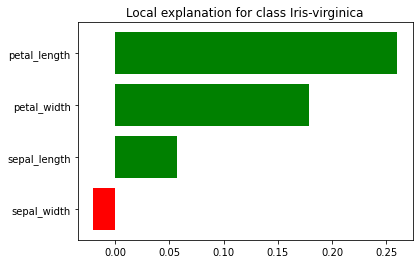

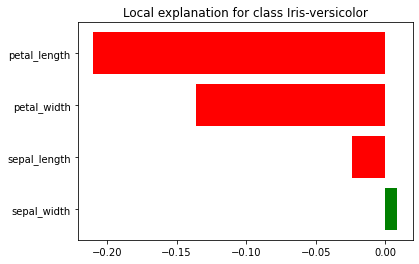

In [4]:
importlib.reload(lime.lime_tabular_mod)
explainer = lime.lime_tabular_mod.LimeTabularExplainerMod(
    train_set,
    feature_names = attributes,
    class_names = unique_labels,
    discretize_continuous=False,
    sample_around_instance=True
)
explanation = explainer.explain_instance(
    test_instance,
    random_forest.predict_proba,
    num_features = 4,
    top_labels = 3
)
for label in explanation.top_labels[:2]:
    _ = explanation.as_pyplot_figure(label)
iris_dataset.loc[
        iris_dataset.index == jackknife_idx
    ]

In [5]:
print(explanation.get_prediction_for_explained_model())
print(explanation.get_prediction_for_surrogate_model())
print(explanation.get_prediction_for_surrogate_model(normalized=True))
print(explanation.get_scores_for_surrogate_model())
print(explanation.get_losses_for_surrogate_model())
print(explanation.get_fidelity_loss_on_explanation())
print(explanation.get_fidelity_loss_on_generated_data())


[0. 0. 1.]
[0.05999782576484805, 0.36750605734569847, 0.5724961168894536]
[0.24817044 0.33751974 0.41430982]
[0.23378191694035722, 0.43852930331813433, 0.6295375043261984]
[0.020311848427224416, 0.06542976779549409, 0.04281216110187836]
0.17284704212217675
0.06631009224999727


array([0.17284704, 0.06232472, 0.08071723, ..., 0.05879086, 0.03029256,
       0.1164483 ])

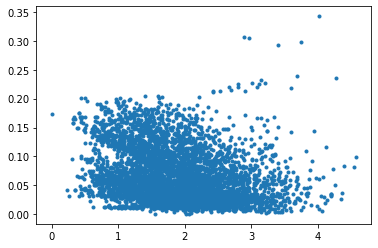

In [6]:
examples_squared_errors = np.mean(explanation.squared_errors_matrix, axis=1)
examples_distances = explanation.training_data_distances
sorted_sequence = np.argsort(examples_distances)

plt.scatter(
    examples_distances[sorted_sequence],
    examples_squared_errors[sorted_sequence],
    marker=".")

examples_squared_errors

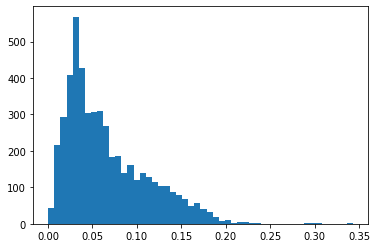

In [7]:
plt.hist(examples_squared_errors, bins=50)
plt.show()

